 Heading    

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from collections import defaultdict
from PIL import Image

import warnings
warnings.filterwarnings("ignore")


In [4]:
#Read in label class file for see classes of signs.
path = r'C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\labels.csv'
df = pd.read_csv(path)

In [5]:
#Visually inspect the classes and see what type of images I am working with.
df

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  58 non-null     int64 
 1   Name     58 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [112]:
# Inspecting duplicate names in the df and printing out all instances of duplicate names, to make plotting a bit later more clean.
duplicate_names = df[df['Name'].duplicated(keep=False)]['Name'].unique()

# Display the duplicate names
print(duplicate_names)

['Speed limit (40km/h)' 'Speed limit (50km/h)' 'Bicycles crossing']


In [13]:
#Setting "dataset" variable to the path where my data images are stored
dataset = r'C:\Users\Chris\Documents\Flatiron\Course Materials\Phase_4\P4_Project\traffic_Data\DATA'

### 1. What are the class distribution among the images?

In [98]:
#Inspecting the data in a DF.
display_data

,Class_Name,num_images
0,Speed limit (5km/h),118
1,Speed limit (15km/h),40
2,Dont Go straight,70
3,Dont Go Left,138
4,Dont Go Left or Right,96
5,Dont Go Right,36
6,Dont overtake from Left,128
7,No Uturn,22
8,No Car,142
9,No horn,130


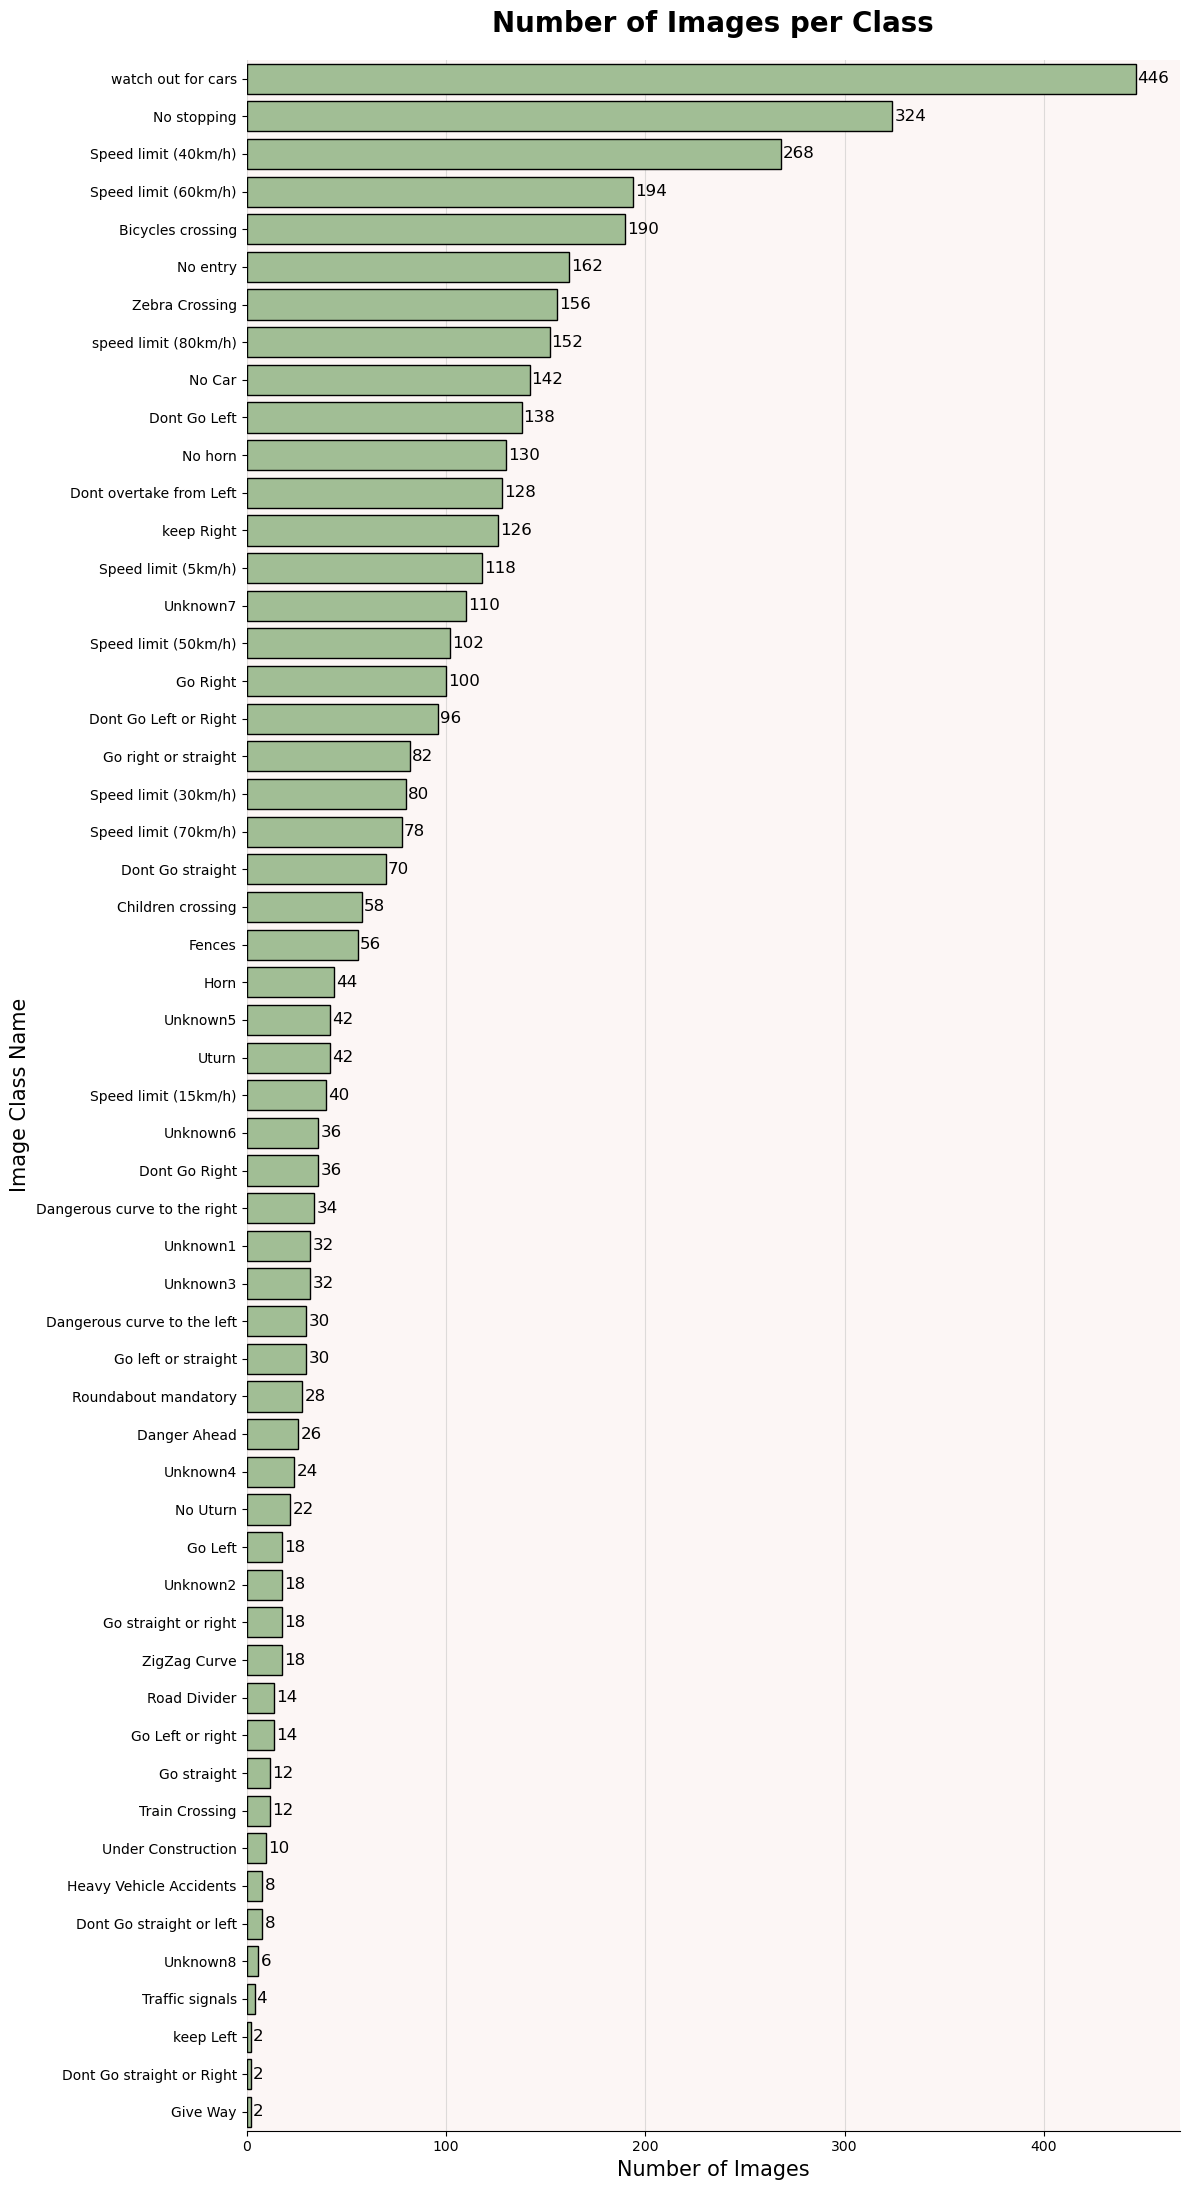

In [159]:
#Set data to an empty list to extract the data from the directory and build a dataframe off of it.
data = []

# Loop through each folder (class ID) inside the dataset directory
for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    
    # Check if it is a directory
    if os.path.isdir(folder_path):
        # Filter only image files based on their extensions
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
       
        # Check if the folder name is an integer, else skip
        try:
            class_id = int(folder)
            class_name = df['Name'][class_id]  # Get the class name from the DataFrame
        except (ValueError, KeyError):
            print(f"Skipping folder {folder} - invalid class ID or not found in DataFrame.")
            continue
        
        # Append the class name and image count to the data list
        data.append([class_name, num_images])

#Create a DataFrame
display_data = pd.DataFrame(data, columns=['Class_Name', 'num_images'])

#Group by Class_Name to sum up the number of images for duplicate classes
grouped_data = display_data.groupby('Class_Name', as_index=False).agg({'num_images': 'sum'})

#Sort the data by 'num_images' in ascending order for the plot
grouped_data_sorted = grouped_data.sort_values('num_images', ascending=True)

#Set up the plot to visualize our data.
fig, ax = plt.subplots(figsize=(12, len(grouped_data_sorted) * 0.4))
ax.barh(grouped_data_sorted['Class_Name'], grouped_data_sorted['num_images'], color='#A1BE95', edgecolor="black", linewidth=1, zorder=3)

#Add title, x labels, and adjust y limiter to get rid of unneccesary whitespace.
plt.title('Number of Images per Class', fontsize=20, weight='bold', pad=20)
plt.xlabel('Number of Images', fontsize=15)
plt.ylabel('Image Class Name', fontsize=15)
ax.set_ylim(-0.5, len(grouped_data_sorted) - 0.5)
ax.grid(axis='x', alpha=0.4)
ax.set_facecolor('#FCF6F5')

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

#Annotate each bar for their values.
for index, value in enumerate(grouped_data_sorted['num_images']):
    plt.text(value + 1, index, f'{value}', ha='left', va='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### 2. What is the distribution of image aspect ratios?

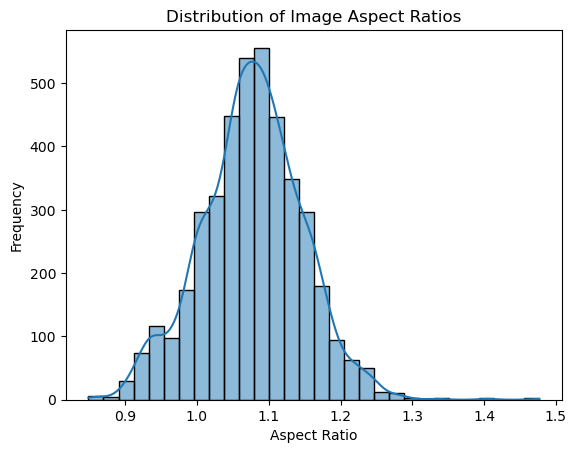

In [87]:
#Empty list to store aspect ratios
aspect_ratios = []

# Loop through each folder (class ID) inside the dataset directory
for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    
    # Check if it's a directory that exist, and loop through each image file in all folders.
    if os.path.isdir(folder_path):
        # Loop through each image file in the folder
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            
            # Check if it's a file (image)
            if os.path.isfile(image_path):
                try:
                    # Open the image and get its dimensions
                    with Image.open(image_path) as img:
                        width, height = img.size
                        # Calculate the aspect ratio (width / height)
                        aspect_ratio = width / height
                        aspect_ratios.append(aspect_ratio)
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

# Convert aspect ratios list to a DataFrame for visualization
aspect_data = pd.DataFrame(aspect_ratios, columns=['Aspect_Ratio'])


sns.histplot(aspect_data['Aspect_Ratio'], bins=30, kde=True)
plt.title("Distribution of Image Aspect Ratios")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.show()

### 3. What is the mean distribution of widths and heights of all the images?

Average width: 152.13717026378896 and height: 140.85659472422063


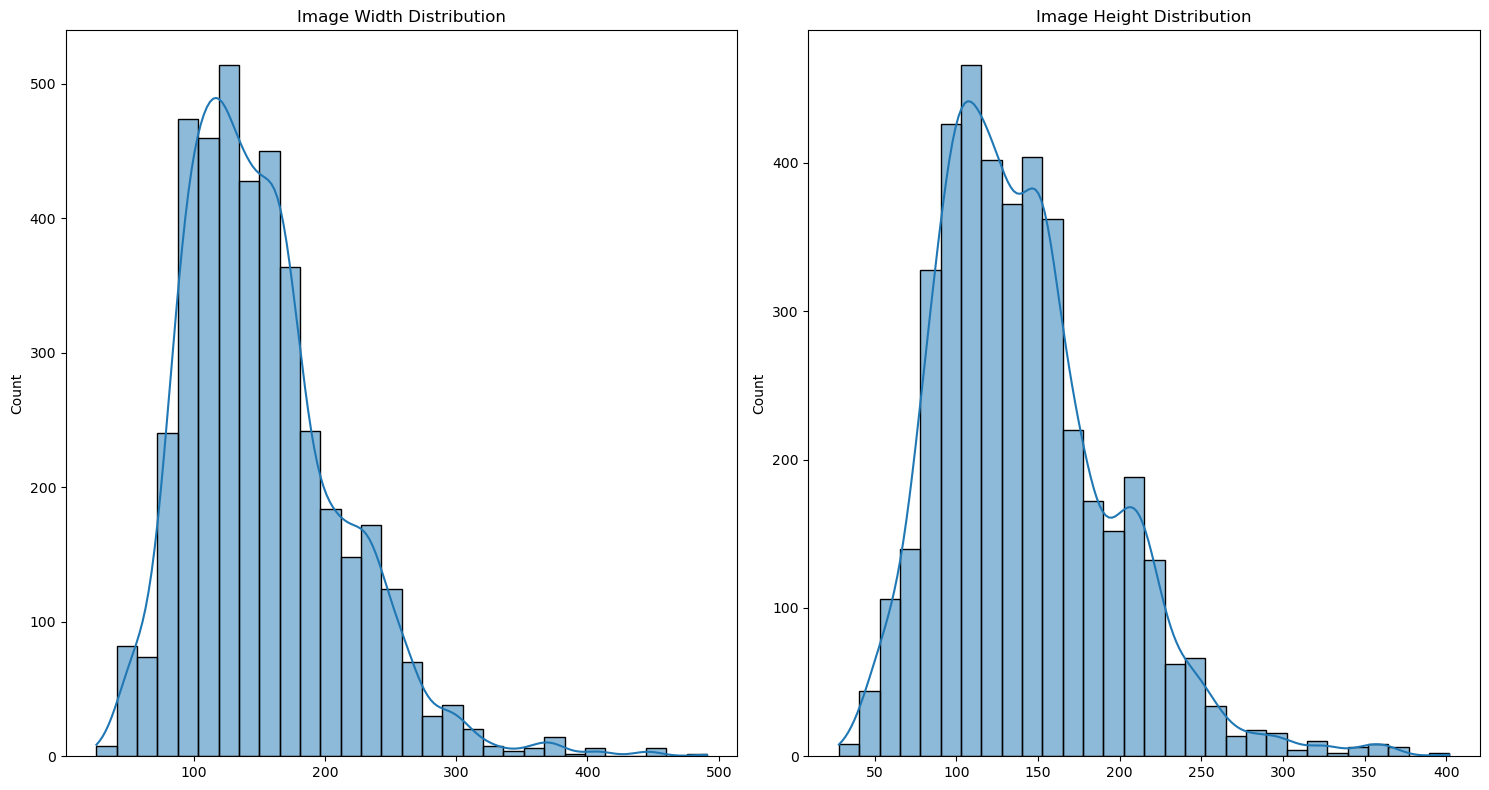

In [78]:
# Lists to store width and height of images
width_list = []
height_list = []

# Loop through each folder in the dataset
for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Loop through each image file in the folder
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            
            # Open image and get its dimensions
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    width_list.append(width)
                    height_list.append(height)
            except Exception as e:
                print(f"Error opening {image_path}: {e}")

# Calculate average width and height
average_width = sum(width_list) / len(width_list) 
average_height = sum(height_list) / len(height_list) 

print(f'Average width: {average_width} and height: {average_height}')

# Plot the width and height distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Plot for image widths
sns.histplot(width_list, ax=ax[0], bins=30, kde=True)
ax[0].set_title('Image Width Distribution')

# Plot for image heights
sns.histplot(height_list, ax=ax[1], bins=30, kde=True)
ax[1].set_title('Image Height Distribution')

plt.tight_layout()
plt.show()

### 4. What are the average Red channel intensities among the images?

In [54]:
# Initialize a list to store RGB channel intensities
rgb_data = []

# Loop through each folder and image
for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            
            # Open the image
            with Image.open(image_path) as img:
                # Convert the image to RGB 
                img = img.convert('RGB')
                
                # Convert image data to a NumPy array (easier to manipulate)
                img_array = np.array(img)
                
                # Calculate mean intensity for each channel (R, G, B)
                red_mean = np.mean(img_array[:, :, 0])  # Red channel
                green_mean = np.mean(img_array[:, :, 1])  # Green channel
                blue_mean = np.mean(img_array[:, :, 2])  # Blue channel
                
                # Store the results in the list
                rgb_data.append([filename, red_mean, green_mean, blue_mean])

# Create a DataFrame to display the RGB intensities
rgb_df = pd.DataFrame(rgb_data, columns=['Image_Name', 'Red_Intensity', 'Green_Intensity', 'Blue_Intensity'])

In [74]:
#Inspect the df of all the image intensities of RGB values.
rgb_df.head()

,Image_Name,Red_Intensity,Green_Intensity,Blue_Intensity
0,000_0001.png,125.130830,102.479653,92.594683
1,000_0002.png,124.596709,96.950552,88.883765
2,000_0003.png,126.347656,103.322170,97.209529
3,000_0004.png,120.299174,92.751322,85.797934
4,000_0005.png,116.834804,89.274101,82.158333


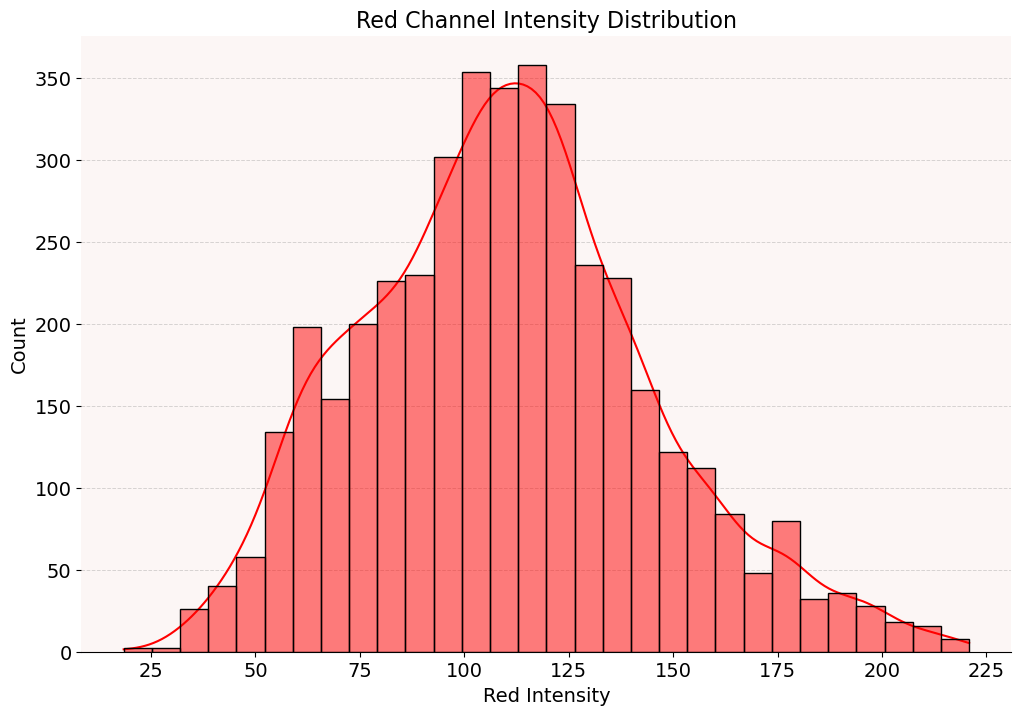

In [160]:
# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram for the Red channel
sns.histplot(rgb_df['Red_Intensity'], bins=30, color='red', kde=True, zorder=3)

#Set Title, x & y axis names, face color
plt.title('Red Channel Intensity Distribution', fontsize=16)
ax.set_xlabel("Red Intensity",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
ax.tick_params(labelsize=14)
ax.set_facecolor('#FCF6F5')

#Remove lines of grid perimeter to make more appealing.
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

#Set background of grid to custom color.
plt.grid(True, axis='y', linestyle='--', linewidth=0.7, color='gray', alpha=0.3, zorder=1)

#Display plot
plt.show()



### 5. What are the average Green channel intensities among the images?

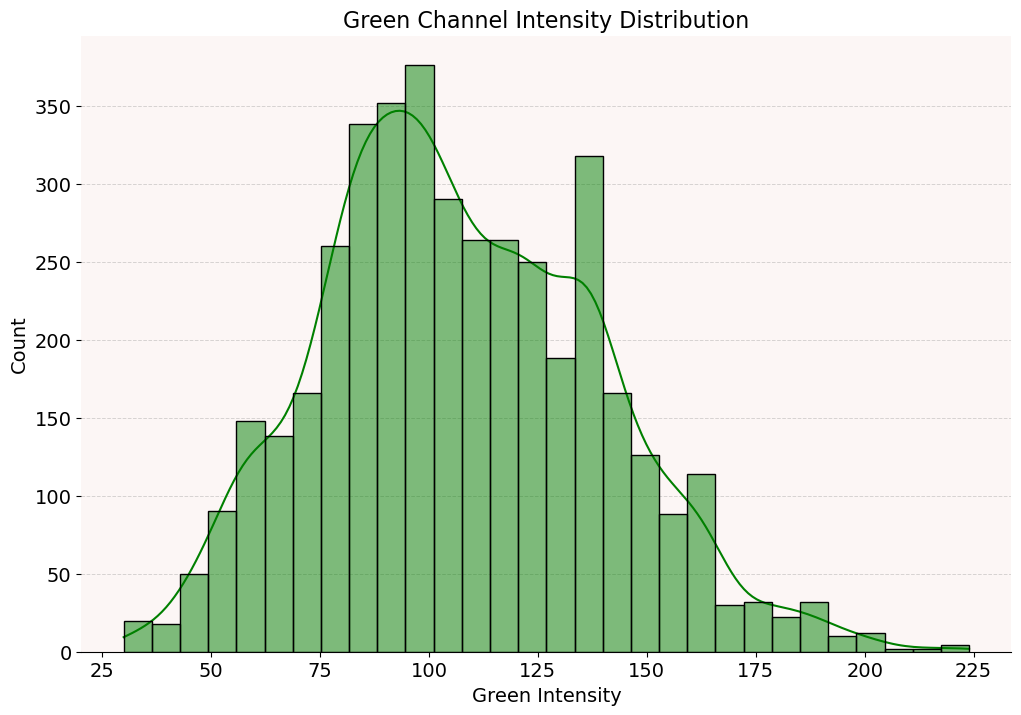

In [168]:
# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram for the Green channel
sns.histplot(rgb_df['Green_Intensity'], bins=30, color='green', kde=True, zorder=3)

#Set Title, x & y axis names, face color
plt.title('Green Channel Intensity Distribution', fontsize=16)
ax.set_xlabel("Green Intensity",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
ax.tick_params(labelsize=14)
ax.set_facecolor('#FCF6F5')

#Remove lines of grid perimeter to make more appealing.
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

#Set background of grid to custom color.
plt.grid(True, axis='y', linestyle='--', linewidth=0.7, color='gray', alpha=0.3, zorder=1)

#Display plot
plt.show()

### 6. What are the average Blue channel intensities among the images?

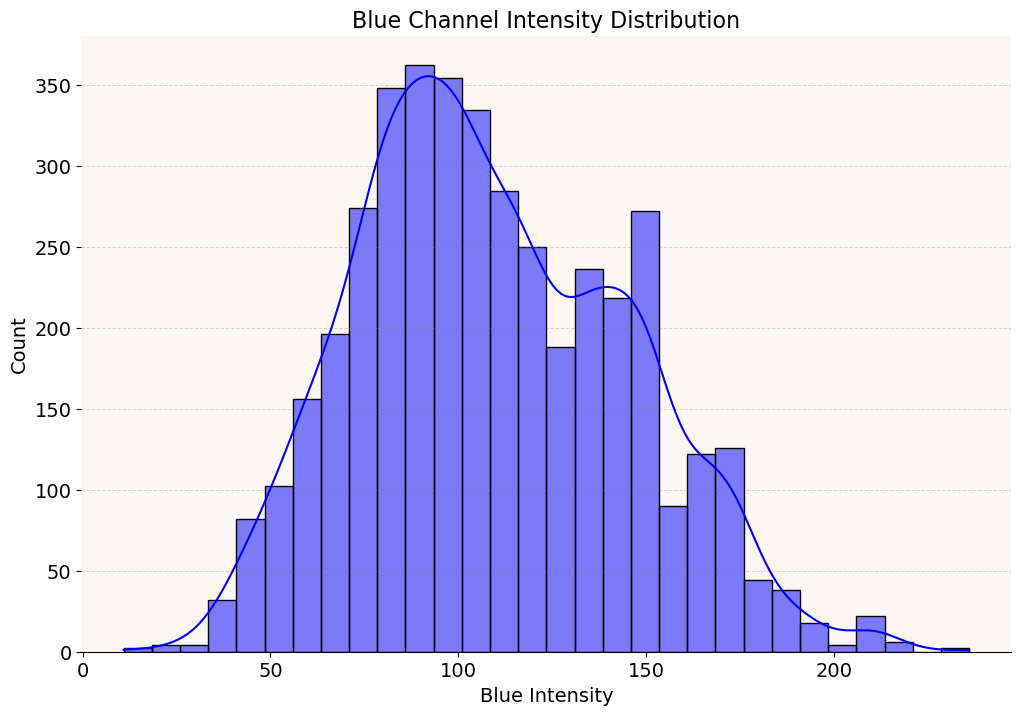

In [166]:
# Set the size of the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram for the Blue channel
sns.histplot(rgb_df['Blue_Intensity'], bins=30, color='blue', kde=True)

#Set Title, x & y axis names, face color
plt.title('Blue Channel Intensity Distribution', fontsize=16)
ax.set_xlabel("Blue Intensity",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
ax.tick_params(labelsize=14)
ax.set_facecolor('#FCF6F5')

#Remove lines of grid perimeter to make more appealing.
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

#Set background of grid to custom color.
plt.grid(True, axis='y', linestyle='--', linewidth=0.7, color='gray', alpha=0.3, zorder=1)

#Display plot
plt.show()

### 7. How many total Images are there in training?

In [53]:
# Make a counter to count images
total_images = 0

# Loop through each folder inside the dataset directory
for folder in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder)
    
    if os.path.isdir(folder_path):
        # Count the number of image files in the folder
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        
        # Add the count to the total
        total_images += num_images

# Output the total number of images
print(f"Total number of images: {total_images}")

Total number of images: 4170
